# OASIS toy experiments

Comparing (stochastic) gradient descent with OASIS on a few toy problems -- the first steps in the preconditioned SGD project.

OASIS implemented from Jahani et al., 2021.

https://arxiv.org/pdf/2109.05198.pdf

In [1]:
import jax
import jax.numpy as jnp
from jax.config import config
from jax import random
from jax import jvp, grad
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from simplecryoem.algorithm import (
    sgd,
    oasis,
    oasis_adaptive
)
from simplecryoem.algorithm import conjugate_gradient as cg

In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

#### Hutchinson's method

In [3]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

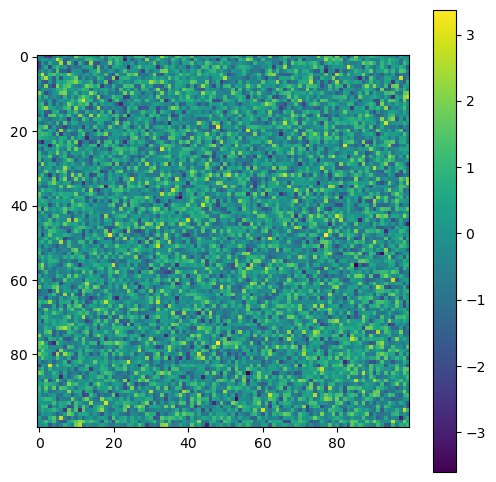

In [4]:
key, subkey = random.split(key)

A = random.normal(subkey, (n, n), dtype=jnp.complex128)
A = A.T + A

plt.imshow(jnp.real(A))
plt.colorbar()

In [5]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

# z * A @ z

In [6]:
zAz = jax.vmap(lambda zi: zi * (A @ zi))(z)
# plt.imshow(zAz)

In [7]:
d = np.zeros((iters, n), dtype=A.dtype)
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i - 1] + zAz[i]

for i in range(1, iters):
    d[i] = d[i] / (i + 1)

In [8]:
err = jnp.mean((d - jnp.diag(A)) ** 2, axis=1)

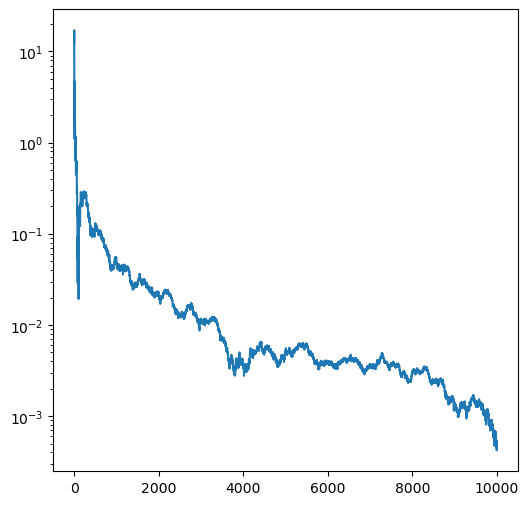

In [9]:
plt.semilogy(jnp.abs(err))

#### Hessian-vector product in JaX

In [10]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [11]:
b = A @ x0
f = lambda x: jnp.real(jnp.mean(jnp.conj(A @ x - b) * (A @ x - b)))

In [12]:
# Naive
def hvp0(f, x, v):
    return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)


# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [13]:
%timeit hvp0(f, x, v)

%timeit hvp(f, (x,), (v,))

v1 = hvp0(f, x, v)
v2 = hvp(f, (x,), (v,))
jnp.sum(jnp.abs(v1 - v2))

4.67 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.77 ms ± 81.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Array(0., dtype=float64)

#### Toy problem

Condition number =  3.33e+05


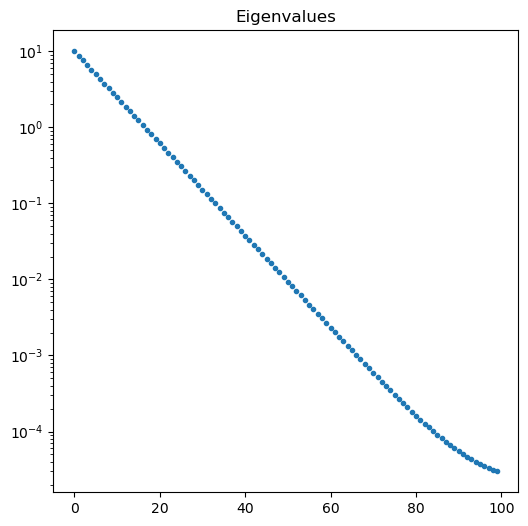

In [14]:
key, *subkey = random.split(key, 3)

x_gt = random.normal(subkey[0], (n,), dtype=jnp.complex128)

A = random.normal(subkey[1], (n, n), dtype=x_gt.dtype)
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5, 1, n))
d = d + jnp.abs(jnp.min(d) * 2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert jnp.sum(evals < 0) == 0
assert jnp.max(jnp.imag(evals)) < 1e-12
# assert(jnp.max(jnp.abs(A.T - A)) == 0)
# assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)

evals = jnp.real(evals)
plt.semilogy(evals, ".")
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [15]:
sig_noise = 1
lam = 0.1

key, subkey = random.split(key)

b = A @ x_gt + random.normal(subkey, (n,)) * sig_noise

F = jax.jit(
    lambda x: jnp.real(
        jnp.mean(jnp.conj(A @ x - b) * (A @ x - b)) + lam * jnp.mean(jnp.conj(x) * x)
    )
)
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
# hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v: hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
# print(f"hessianF(x_gt) = {hessianF(x_gt)}")

f(x_gt + 1) = 8.542399517882556
f(x_gt) = 1.0597508305853975
gradF(x_gt) = [-0.01963603-1.95905206e-03j  0.00354226+1.81833589e-03j
 -0.0152497 -1.37832366e-03j  0.08045964+1.71388959e-03j
  0.02460394+3.45869286e-04j -0.03403817-9.50956957e-04j
  0.02130584+2.04998780e-03j  0.01132831-4.13860744e-04j
 -0.05921172+2.27109943e-03j  0.0154637 -4.33926880e-04j
 -0.03677799-1.29657125e-03j  0.09241541+1.55697120e-03j
 -0.0864657 +4.35076316e-04j -0.01339623-5.25658441e-04j
  0.02676298+1.68331025e-03j  0.0339894 +7.31740813e-04j
 -0.04687858+4.25978540e-06j  0.03742791-6.80905095e-04j
 -0.04169643+1.50918452e-03j -0.02326829+7.99798868e-04j
 -0.06632333+1.74936895e-03j  0.03356031+7.54713535e-04j
  0.1289374 -1.30076869e-03j  0.03008432+1.47008173e-04j
  0.05437357-8.05138302e-04j  0.04540365-6.90510880e-04j
  0.01926461-2.17982731e-03j -0.04254186+8.76533637e-04j
  0.02872789+1.16502418e-03j -0.07331172-1.41074819e-03j
 -0.02229663+5.63258837e-04j -0.03610326+2.17404793e-04j
  0.04405431+

In [16]:
def gd(F, gradF, eta, w0, N_iter=20, iter_display=1):
    loss = []
    for k in range(1, N_iter + 1):
        w1 = w0 - eta * jnp.conj(gradF(w0))
        loss_i = F(w1)
        loss.append(loss_i)

        w0 = w1

        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")

    return w1, jnp.array(loss)


def newton(F, gradF, hessianF, w0, N_iter=20, iter_display=1):
    loss = []
    for k in range(1, N_iter + 1):
        G = gradF(w0)
        H = hessianF(w0)

        w1 = w0 - jnp.conj(jnp.linalg.inv(H) @ G)
        loss_i = F(w1)
        loss.append(loss_i)

        w0 = w1

        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")

    return w1, jnp.array(loss)

In [17]:
N_iter = 1000
eta = 1e-3  # 0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display=200)

Iter 200: loss = 5.302873609272033
Iter 400: loss = 4.289482250807342
Iter 600: loss = 3.721767729751337
Iter 800: loss = 3.381725525776721
Iter 1000: loss = 3.1630935682045727


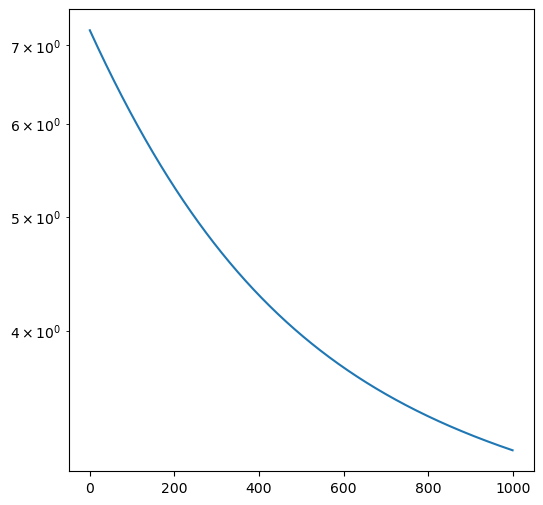

In [18]:
plt.semilogy(loss_gd)

In [19]:
# N_iter = 10

# x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [20]:
# plt.plot(loss_n)

In [21]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv: jnp.conj(gradF(vv)) + Ab)

x_cg, kk, x_cg_all = cg(AA, Ab, x0, N_iter, verbose=True)
loss_cg = jax.vmap(F)(jnp.array(x_cg_all))

  cg iter 0 ||r|| = 1.0563996740235684
  cg iter 10 ||r|| = 0.09186846426183241
  cg iter 20 ||r|| = 0.013684759891635336
  cg iter 30 ||r|| = 0.0002771403955573868
  cg iter 40 ||r|| = 8.129514826223391e-06
  cg iter 50 ||r|| = 2.703907814914831e-07
  cg iter 60 ||r|| = 2.8151372520184795e-08
  cg iter 70 ||r|| = 7.388266338507045e-10
  cg iter 80 ||r|| = 4.899043231972926e-11
  cg iter 90 ||r|| = 1.1999380524032198e-11
  cg iter 100 ||r|| = 5.201423039297919e-12
  cg iter 110 ||r|| = 4.990763911956131e-13
  cg iter 120 ||r|| = 3.51865225133471e-13
  cg iter 130 ||r|| = 9.446070891841063e-14
  cg iter 140 ||r|| = 1.0450350324748802e-13
  cg iter 150 ||r|| = 4.0229273667871403e-14
  cg iter 160 ||r|| = 3.519574668731923e-14
  cg iter 170 ||r|| = 5.871559518804979e-14
  cg iter 180 ||r|| = 4.135817892007168e-14
  cg iter 190 ||r|| = 3.9696970267504626e-14
  cg iter 200 ||r|| = 4.7453394558535246e-14
  cg iter 210 ||r|| = 3.764780660601011e-14
  cg iter 220 ||r|| = 3.210018142921771e-14


In [22]:
print(F(x_gt))
print(F(x_cg))
print(F(x_gd))
# print(F(x_n))

1.0597508305853975
1.878070840709799
3.1630935682045727


#### OASIS

In [23]:
Fidx = jax.jit(lambda x, idx: F(x))
gradFidx = jax.jit(lambda x, idx: jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx: hvp(F, (x,), (v,)))

In [24]:
# Estimating D0

iters = 100000
key, *subkeys = random.split(key, iters + 1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)

    zD0z += z * hvpFidx(x0, z, 1)

D0 = jnp.array(zD0z / iters)

# D0exact = jnp.diag(hessianF(x0)) # Cheating a bit

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:15<00:00, 6281.44it/s]


In [25]:
# plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [26]:
N_iter = 1000
beta2 = 0.99
eta = 0.1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0.1  # 0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o, _, _ = oasis(
    subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display=100
)

Epoch 100/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 513.57it/s, eta=1.000e-01, loss=1.984e+00]


  Loss =  1.98394718e+00
  eta = 0.1
  alpha= 0.1
Epoch 200/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 477.77it/s, eta=1.000e-01, loss=1.939e+00]

  Loss =  1.93878732e+00
  eta = 0.1
  alpha= 0.1


Epoch 300/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 599.87it/s, eta=1.000e-01, loss=1.917e+00]


  Loss =  1.91699746e+00
  eta = 0.1
  alpha= 0.1
Epoch 400/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.88it/s, eta=1.000e-01, loss=1.904e+00]

  Loss =  1.90409721e+00
  eta = 0.1
  alpha= 0.1


Epoch 500/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 655.77it/s, eta=1.000e-01, loss=1.896e+00]

  Loss =  1.89587729e+00
  eta = 0.1
  alpha= 0.1


Epoch 600/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 620.73it/s, eta=1.000e-01, loss=1.890e+00]

  Loss =  1.89041651e+00
  eta = 0.1
  alpha= 0.1


Epoch 700/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 650.99it/s, eta=1.000e-01, loss=1.887e+00]

  Loss =  1.88668566e+00
  eta = 0.1
  alpha= 0.1


Epoch 800/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 615.81it/s, eta=1.000e-01, loss=1.884e+00]

  Loss =  1.88411254e+00
  eta = 0.1
  alpha= 0.1


Epoch 900/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 592.16it/s, eta=1.000e-01, loss=1.882e+00]

  Loss =  1.88232456e+00
  eta = 0.1
  alpha= 0.1


Epoch 1000/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 636.85it/s, eta=1.000e-01, loss=1.881e+00]

  Loss =  1.88107540e+00
  eta = 0.1
  alpha= 0.1


In [27]:
N_iter = 1000
beta2 = 0.99
eta0 = 0.1  # 0.1/0.001/0.01/0.15

alpha = 0.1  # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta0,
    D0,
    beta2,
    alpha,
    N_iter,
    iter_display=500,
)

Epoch 500/1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 424.27it/s, loss=1.881e+00]

  Loss =  1.881e+00


Epoch 1000/1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 412.22it/s, loss=1.878e+00]

  Loss =  1.878e+00


0.8626668443027755
1.301071205205325
0.8761694865027515
0.8604189417335028


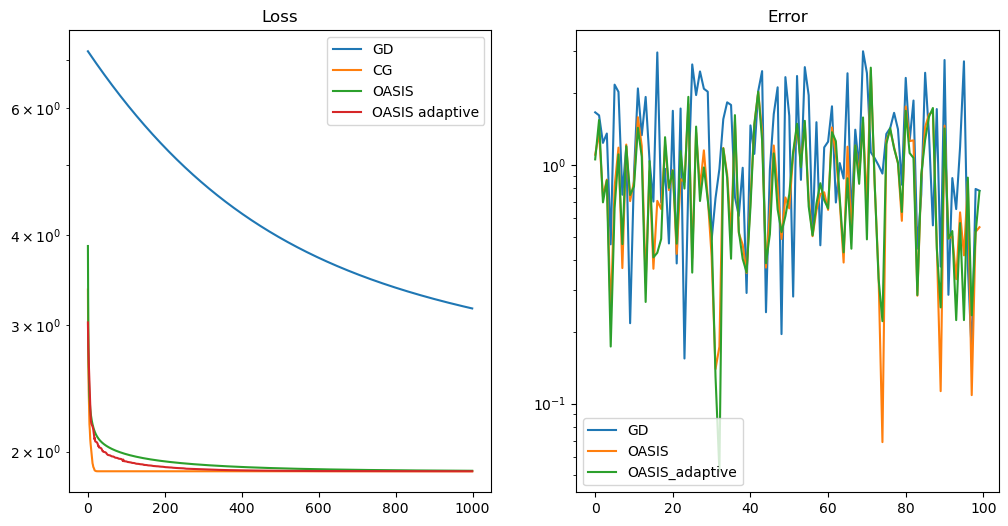

In [28]:
# print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt - x_cg)))
print(jnp.mean(jnp.abs(x_gt - x_gd)))
print(jnp.mean(jnp.abs(x_gt - x_o)))
print(jnp.mean(jnp.abs(x_gt - x_oa)))

plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)

nn0 = 0
nn1 = 1000
# plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_cg[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
# plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "CG", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1, 2, 2)
# plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt - x_gd))
plt.semilogy(jnp.abs(x_gt - x_o))
plt.semilogy(jnp.abs(x_gt - x_oa))
plt.legend(["GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"] = 6, 6

### Stochastic - sum of operators

In [29]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

Generate $N$ operators to create a loss function to run SGD/OASIS on:

In [30]:
sig_noise = 10
lam = 0.1

In [31]:
n = 100
N = 1000

key, subkey = random.split(key)

x_gt = random.normal(subkey, (n,), dtype=jnp.complex128)

ops = []
b = []
for i in range(N):
    key, *subkeys = random.split(key, 4)

    A = random.normal(subkeys[0], (n, n), dtype=x_gt.dtype)
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)

    d = jnp.logspace(10, -5, n) + random.normal(subkeys[1], (n,), dtype=jnp.double) * 10
    d = d + jnp.abs(jnp.min(d) * 2)

    A = v.T @ jnp.diag(d) @ v
    ops.append(A)

    bn = A @ x_gt + random.normal(subkeys[2], (n,), dtype=x_gt.dtype) * sig_noise
    b.append(bn)

    # print(jnp.mean((A@x_gt - bn)**2))

ops = jnp.array(ops)
b = jnp.array(b)

In [32]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

 4.62e+08


In [33]:
print(jnp.max(w))
print(jnp.min(w))

10000000040.388899
21.63755572338564


In [34]:
def loss_term(x, A, b):
    return (
        1
        / 2
        * jnp.real(
            jnp.mean(jnp.conj(A @ x - b) * (A @ x - b))
            + lam * jnp.mean(jnp.conj(x) * x)
        )
    )


def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes=(None, 0, 0))(x, ops, b))


def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)


def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y: grad_loss_func(y, ops, b), (x,), (v,))[1]

In [35]:
idx = np.random.permutation(N)[: N // 3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

48.33054603206093
50.11836749954431
(100,)
(100,)
(100,)
(100,)


In [36]:
key, subkey = random.split(key)

hessianF = lambda x: jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx: loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx: grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx: hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = random.normal(subkey, (n,), dtype=x_gt.dtype)

In [37]:
Fidx(x_gt, jnp.arange(N))

Array(50.1183675, dtype=float64)

In [38]:
# D0 = jnp.ones((nx,nx,nx))  #<--- not very good
# D0exact = jnp.diag(hessianF(x0)) # This is cheating

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2 * iters + 1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2 * i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2 * i + 1], N)[:batch_sz]

    zD0z += z * hvpFidx(x0, z, idx)

D0 = jnp.array(zD0z / iters)


# plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 508.85it/s]


In [39]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os, _, _ = oasis(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=20,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.02it/s, eta=1.000e-01, loss=8.883e+14]


  Loss =  1.04276759e+15
  eta = 0.1
  alpha= 0
Epoch 2/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 243.03it/s, eta=1.000e-01, loss=2.167e+12]


  Loss =  2.20477983e+12
  eta = 0.1
  alpha= 0
Epoch 3/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 246.60it/s, eta=1.000e-01, loss=6.443e+09]


  Loss =  6.62651141e+09
  eta = 0.1
  alpha= 0
Epoch 4/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 244.74it/s, eta=1.000e-01, loss=1.907e+07]


  Loss =  2.41996406e+07
  eta = 0.1
  alpha= 0
Epoch 5/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 242.00it/s, eta=1.000e-01, loss=8.339e+04]


  Loss =  8.50412748e+04
  eta = 0.1
  alpha= 0
Epoch 6/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 246.60it/s, eta=1.000e-01, loss=4.032e+02]


  Loss =  3.75052409e+02
  eta = 0.1
  alpha= 0
Epoch 7/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 244.78it/s, eta=1.000e-01, loss=5.099e+01]


  Loss =  5.17663087e+01
  eta = 0.1
  alpha= 0
Epoch 8/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 242.71it/s, eta=1.000e-01, loss=5.050e+01]


  Loss =  5.01783177e+01
  eta = 0.1
  alpha= 0
Epoch 9/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 244.97it/s, eta=1.000e-01, loss=5.131e+01]


  Loss =  5.06157126e+01
  eta = 0.1
  alpha= 0
Epoch 10/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 243.28it/s, eta=1.000e-01, loss=4.970e+01]


  Loss =  5.01958730e+01
  eta = 0.1
  alpha= 0
Epoch 11/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 243.01it/s, eta=1.000e-01, loss=4.880e+01]


  Loss =  5.01582547e+01
  eta = 0.1
  alpha= 0
Epoch 12/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 241.96it/s, eta=1.000e-01, loss=5.022e+01]


  Loss =  5.02378271e+01
  eta = 0.1
  alpha= 0
Epoch 13/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 243.78it/s, eta=1.000e-01, loss=4.893e+01]


  Loss =  5.02295574e+01
  eta = 0.1
  alpha= 0
Epoch 14/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 246.51it/s, eta=1.000e-01, loss=5.101e+01]


  Loss =  5.01613552e+01
  eta = 0.1
  alpha= 0
Epoch 15/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 246.28it/s, eta=1.000e-01, loss=5.208e+01]


  Loss =  5.04508310e+01
  eta = 0.1
  alpha= 0
Epoch 16/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 241.29it/s, eta=1.000e-01, loss=4.903e+01]


  Loss =  5.01522154e+01
  eta = 0.1
  alpha= 0
Epoch 17/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 240.94it/s, eta=1.000e-01, loss=4.976e+01]


  Loss =  5.01458879e+01
  eta = 0.1
  alpha= 0
Epoch 18/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 242.36it/s, eta=1.000e-01, loss=5.124e+01]


  Loss =  5.01488950e+01
  eta = 0.1
  alpha= 0
Epoch 19/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 243.62it/s, eta=1.000e-01, loss=5.023e+01]


  Loss =  5.01570174e+01
  eta = 0.1
  alpha= 0
Epoch 20/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 242.68it/s, eta=1.000e-01, loss=5.080e+01]


  Loss =  5.01738633e+01
  eta = 0.1
  alpha= 0


In [40]:
N_epoch = 20
beta2 = 0.99
eta = 0.01  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=20,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.31it/s, loss=4.347e+15]


  Loss =  5.836e+15
Epoch 2/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 206.17it/s, loss=6.011e+13]


  Loss =  5.474e+13
Epoch 3/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 203.87it/s, loss=6.809e+11]


  Loss =  6.876e+11
Epoch 4/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 205.30it/s, loss=1.033e+10]


  Loss =  1.188e+10
Epoch 5/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 204.16it/s, loss=2.080e+08]


  Loss =  2.249e+08
Epoch 6/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 205.94it/s, loss=3.970e+06]


  Loss =  4.728e+06
Epoch 7/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 202.24it/s, loss=1.257e+05]


  Loss =  1.419e+05
Epoch 8/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 200.26it/s, loss=2.855e+03]


  Loss =  2.942e+03
Epoch 9/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 201.99it/s, loss=8.940e+01]


  Loss =  9.145e+01
Epoch 10/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 203.29it/s, loss=5.113e+01]


  Loss =  5.111e+01
Epoch 11/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 203.69it/s, loss=5.027e+01]


  Loss =  5.020e+01
Epoch 12/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 200.99it/s, loss=4.993e+01]


  Loss =  5.011e+01
Epoch 13/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 204.66it/s, loss=5.066e+01]


  Loss =  5.016e+01
Epoch 14/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 207.56it/s, loss=5.082e+01]


  Loss =  5.013e+01
Epoch 15/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 203.78it/s, loss=4.986e+01]


  Loss =  5.012e+01
Epoch 16/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 200.82it/s, loss=5.155e+01]


  Loss =  5.011e+01
Epoch 17/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 207.61it/s, loss=5.095e+01]


  Loss =  5.010e+01
Epoch 18/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 199.87it/s, loss=4.947e+01]


  Loss =  5.014e+01
Epoch 19/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 204.90it/s, loss=5.094e+01]


  Loss =  5.011e+01
Epoch 20/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 202.26it/s, loss=4.930e+01]


  Loss =  5.017e+01


In [41]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o, _, _ = oasis(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=None,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it, eta=1.000e-01, loss=1.404e+18]


  Loss =  1.40444423e+18
  eta = 0.1
  alpha= 0
Epoch 2/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s, eta=1.000e-01, loss=1.144e+18]


  Loss =  1.14372743e+18
  eta = 0.1
  alpha= 0
Epoch 3/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s, eta=1.000e-01, loss=9.486e+17]


  Loss =  9.48570049e+17
  eta = 0.1
  alpha= 0
Epoch 4/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s, eta=1.000e-01, loss=7.936e+17]


  Loss =  7.93566781e+17
  eta = 0.1
  alpha= 0
Epoch 5/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.97it/s, eta=1.000e-01, loss=6.676e+17]


  Loss =  6.67555050e+17
  eta = 0.1
  alpha= 0
Epoch 6/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s, eta=1.000e-01, loss=5.638e+17]


  Loss =  5.63836263e+17
  eta = 0.1
  alpha= 0
Epoch 7/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s, eta=1.000e-01, loss=4.779e+17]


  Loss =  4.77853243e+17
  eta = 0.1
  alpha= 0
Epoch 8/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.03it/s, eta=1.000e-01, loss=4.062e+17]


  Loss =  4.06227373e+17
  eta = 0.1
  alpha= 0
Epoch 9/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s, eta=1.000e-01, loss=3.463e+17]


  Loss =  3.46313981e+17
  eta = 0.1
  alpha= 0
Epoch 10/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s, eta=1.000e-01, loss=2.960e+17]


  Loss =  2.96021334e+17
  eta = 0.1
  alpha= 0
Epoch 11/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s, eta=1.000e-01, loss=2.537e+17]


  Loss =  2.53665690e+17
  eta = 0.1
  alpha= 0
Epoch 12/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.89it/s, eta=1.000e-01, loss=2.179e+17]


  Loss =  2.17882146e+17
  eta = 0.1
  alpha= 0
Epoch 13/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.03it/s, eta=1.000e-01, loss=1.876e+17]


  Loss =  1.87563776e+17
  eta = 0.1
  alpha= 0
Epoch 14/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s, eta=1.000e-01, loss=1.618e+17]


  Loss =  1.61801164e+17
  eta = 0.1
  alpha= 0
Epoch 15/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s, eta=1.000e-01, loss=1.399e+17]


  Loss =  1.39853409e+17
  eta = 0.1
  alpha= 0
Epoch 16/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s, eta=1.000e-01, loss=1.211e+17]


  Loss =  1.21109454e+17
  eta = 0.1
  alpha= 0
Epoch 17/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s, eta=1.000e-01, loss=1.051e+17]


  Loss =  1.05070086e+17
  eta = 0.1
  alpha= 0
Epoch 18/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s, eta=1.000e-01, loss=9.131e+16]


  Loss =  9.13135408e+16
  eta = 0.1
  alpha= 0
Epoch 19/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s, eta=1.000e-01, loss=7.949e+16]


  Loss =  7.94897190e+16
  eta = 0.1
  alpha= 0
Epoch 20/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s, eta=1.000e-01, loss=6.930e+16]

  Loss =  6.93049674e+16
  eta = 0.1
  alpha= 0


In [42]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=None,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s, loss=1.261e+18]


  Loss =  1.261e+18
Epoch 2/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s, loss=1.132e+18]


  Loss =  1.132e+18
Epoch 3/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s, loss=9.673e+17]


  Loss =  9.673e+17
Epoch 4/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s, loss=7.562e+17]


  Loss =  7.562e+17
Epoch 5/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s, loss=5.090e+17]


  Loss =  5.090e+17
Epoch 6/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s, loss=2.660e+17]


  Loss =  2.660e+17
Epoch 7/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s, loss=1.168e+17]


  Loss =  1.168e+17
Epoch 8/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s, loss=1.357e+17]


  Loss =  1.357e+17
Epoch 9/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s, loss=8.193e+16]


  Loss =  8.193e+16
Epoch 10/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s, loss=7.031e+16]


  Loss =  7.031e+16
Epoch 11/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s, loss=6.469e+16]


  Loss =  6.469e+16
Epoch 12/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s, loss=5.990e+16]


  Loss =  5.990e+16
Epoch 13/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s, loss=5.380e+16]


  Loss =  5.380e+16
Epoch 14/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s, loss=4.532e+16]


  Loss =  4.532e+16
Epoch 15/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s, loss=3.423e+16]


  Loss =  3.423e+16
Epoch 16/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s, loss=2.147e+16]


  Loss =  2.147e+16
Epoch 17/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s, loss=1.035e+16]


  Loss =  1.035e+16
Epoch 18/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s, loss=1.171e+16]


  Loss =  1.171e+16
Epoch 19/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s, loss=7.174e+15]


  Loss =  7.174e+15
Epoch 20/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s, loss=6.408e+15]

  Loss =  6.408e+15


In [43]:
N_epoch = 20
eta = 1e-18

key, subkey = random.split(key)
x_sgd, loss_sgd, _, _, _ = sgd(
    key,
    gradFidx,
    Fidx,
    N,
    x0,
    eta,
    N_epoch,
    batch_size=20,
    verbose=True,
    iter_display=1,
)

Epoch 1/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 615.11it/s, eta=1.000e-18, grad=6.413e+16, loss=3.087e+17]


  |Grad| = 6.346e+16
  Loss = 2.99620762e+17
  eta = 1e-18
  alpha = 1e-10
Epoch 2/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 608.72it/s, eta=1.000e-18, grad=1.736e+16, loss=7.483e+16]


  |Grad| = 2.698e+16
  Loss = 6.68500396e+16
  eta = 1e-18
  alpha = 1e-10
Epoch 3/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 604.60it/s, eta=1.000e-18, grad=7.361e+15, loss=1.520e+16]


  |Grad| = 1.292e+16
  Loss = 1.65877608e+16
  eta = 1e-18
  alpha = 1e-10
Epoch 4/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 605.18it/s, eta=1.000e-18, grad=3.594e+15, loss=3.749e+15]


  |Grad| = 6.141e+15
  Loss = 4.43343701e+15
  eta = 1e-18
  alpha = 1e-10
Epoch 5/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 603.12it/s, eta=1.000e-18, grad=2.511e+15, loss=1.141e+15]


  |Grad| = 3.150e+15
  Loss = 1.24018123e+15
  eta = 1e-18
  alpha = 1e-10
Epoch 6/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 603.92it/s, eta=1.000e-18, grad=1.429e+15, loss=3.948e+14]


  |Grad| = 1.722e+15
  Loss = 3.58589135e+14
  eta = 1e-18
  alpha = 1e-10
Epoch 7/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 609.17it/s, eta=1.000e-18, grad=5.108e+14, loss=9.658e+13]


  |Grad| = 9.445e+14
  Loss = 1.06392966e+14
  eta = 1e-18
  alpha = 1e-10
Epoch 8/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 600.36it/s, eta=1.000e-18, grad=3.681e+14, loss=2.742e+13]


  |Grad| = 5.113e+14
  Loss = 3.23887108e+13
  eta = 1e-18
  alpha = 1e-10
Epoch 9/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 618.68it/s, eta=1.000e-18, grad=2.267e+14, loss=1.061e+13]


  |Grad| = 2.705e+14
  Loss = 9.87665128e+12
  eta = 1e-18
  alpha = 1e-10
Epoch 10/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 612.46it/s, eta=1.000e-18, grad=1.059e+14, loss=3.095e+12]


  |Grad| = 1.558e+14
  Loss = 3.09344026e+12
  eta = 1e-18
  alpha = 1e-10
Epoch 11/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 591.95it/s, eta=1.000e-18, grad=7.359e+13, loss=1.113e+12]


  |Grad| = 8.778e+13
  Loss = 9.70138931e+11
  eta = 1e-18
  alpha = 1e-10
Epoch 12/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 592.56it/s, eta=1.000e-18, grad=3.262e+13, loss=3.012e+11]


  |Grad| = 4.951e+13
  Loss = 3.09631457e+11
  eta = 1e-18
  alpha = 1e-10
Epoch 13/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 612.47it/s, eta=1.000e-18, grad=1.546e+13, loss=8.441e+10]


  |Grad| = 2.806e+13
  Loss = 9.88630765e+10
  eta = 1e-18
  alpha = 1e-10
Epoch 14/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 603.65it/s, eta=1.000e-18, grad=1.296e+13, loss=3.828e+10]


  |Grad| = 1.555e+13
  Loss = 3.21979557e+10
  eta = 1e-18
  alpha = 1e-10
Epoch 15/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 597.87it/s, eta=1.000e-18, grad=7.240e+12, loss=1.007e+10]


  |Grad| = 9.058e+12
  Loss = 1.04070108e+10
  eta = 1e-18
  alpha = 1e-10
Epoch 16/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 603.65it/s, eta=1.000e-18, grad=4.681e+12, loss=3.694e+09]


  |Grad| = 5.062e+12
  Loss = 3.40476039e+09
  eta = 1e-18
  alpha = 1e-10
Epoch 17/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 596.69it/s, eta=1.000e-18, grad=2.592e+12, loss=1.069e+09]


  |Grad| = 2.937e+12
  Loss = 1.11683200e+09
  eta = 1e-18
  alpha = 1e-10
Epoch 18/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 609.37it/s, eta=1.000e-18, grad=1.153e+12, loss=3.893e+08]


  |Grad| = 1.628e+12
  Loss = 3.68902534e+08
  eta = 1e-18
  alpha = 1e-10
Epoch 19/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 608.18it/s, eta=1.000e-18, grad=5.233e+11, loss=1.060e+08]


  |Grad| = 9.444e+11
  Loss = 1.22702557e+08
  eta = 1e-18
  alpha = 1e-10
Epoch 20/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.51it/s, eta=1.000e-18, grad=3.986e+11, loss=3.085e+07]


  |Grad| = 5.540e+11
  Loss = 4.07104721e+07
  eta = 1e-18
  alpha = 1e-10


In [44]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1

key, subkey = random.split(key)
x_sgdp, loss_sgdp, _, _, _ = sgd(
    key,
    gradFidx,
    Fidx,
    N,
    x0,
    eta,
    N_epoch,
    batch_size=20,
    D0=D0,
    verbose=True,
    iter_display=1,
)

Epoch 1/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.69it/s, eta=1.000e-01, grad=3.090e+15, loss=9.535e+14]


  |Grad| = 2.585e+16
  Loss = 9.74056791e+14
  eta = 0.1
  alpha = 1e-10
Epoch 2/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 600.92it/s, eta=1.000e-01, grad=8.944e+13, loss=1.463e+12]


  |Grad| = 7.743e+14
  Loss = 1.97417140e+12
  eta = 0.1
  alpha = 1e-10
Epoch 3/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 611.38it/s, eta=1.000e-01, grad=4.640e+12, loss=3.755e+09]


  |Grad| = 3.739e+13
  Loss = 4.81363205e+09
  eta = 0.1
  alpha = 1e-10
Epoch 4/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.39it/s, eta=1.000e-01, grad=3.384e+11, loss=1.369e+07]


  |Grad| = 1.748e+12
  Loss = 1.42083586e+07
  eta = 0.1
  alpha = 1e-10
Epoch 5/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 601.79it/s, eta=1.000e-01, grad=1.793e+10, loss=4.310e+04]


  |Grad| = 9.737e+10
  Loss = 5.13966135e+04
  eta = 0.1
  alpha = 1e-10
Epoch 6/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 613.60it/s, eta=1.000e-01, grad=1.103e+09, loss=2.028e+02]


  |Grad| = 5.785e+09
  Loss = 2.07844497e+02
  eta = 0.1
  alpha = 1e-10
Epoch 7/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 609.31it/s, eta=1.000e-01, grad=8.622e+07, loss=4.989e+01]


  |Grad| = 3.375e+08
  Loss = 5.06797900e+01
  eta = 0.1
  alpha = 1e-10
Epoch 8/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 590.81it/s, eta=1.000e-01, grad=7.037e+07, loss=5.020e+01]


  |Grad| = 9.188e+07
  Loss = 5.03097195e+01
  eta = 0.1
  alpha = 1e-10
Epoch 9/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 606.93it/s, eta=1.000e-01, grad=8.362e+07, loss=4.902e+01]


  |Grad| = 8.432e+07
  Loss = 5.02211695e+01
  eta = 0.1
  alpha = 1e-10
Epoch 10/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 599.96it/s, eta=1.000e-01, grad=7.584e+07, loss=4.844e+01]


  |Grad| = 8.907e+07
  Loss = 5.01850819e+01
  eta = 0.1
  alpha = 1e-10
Epoch 11/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 604.09it/s, eta=1.000e-01, grad=9.739e+07, loss=5.081e+01]


  |Grad| = 8.563e+07
  Loss = 5.01361307e+01
  eta = 0.1
  alpha = 1e-10
Epoch 12/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 604.12it/s, eta=1.000e-01, grad=1.138e+08, loss=5.108e+01]


  |Grad| = 8.905e+07
  Loss = 5.03055670e+01
  eta = 0.1
  alpha = 1e-10
Epoch 13/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.01it/s, eta=1.000e-01, grad=7.398e+07, loss=5.044e+01]


  |Grad| = 8.858e+07
  Loss = 5.02165506e+01
  eta = 0.1
  alpha = 1e-10
Epoch 14/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 605.51it/s, eta=1.000e-01, grad=7.317e+07, loss=4.984e+01]


  |Grad| = 8.600e+07
  Loss = 5.01530839e+01
  eta = 0.1
  alpha = 1e-10
Epoch 15/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 613.01it/s, eta=1.000e-01, grad=5.686e+07, loss=4.978e+01]


  |Grad| = 8.681e+07
  Loss = 5.01348819e+01
  eta = 0.1
  alpha = 1e-10
Epoch 16/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 604.98it/s, eta=1.000e-01, grad=8.902e+07, loss=4.777e+01]


  |Grad| = 8.483e+07
  Loss = 5.01893325e+01
  eta = 0.1
  alpha = 1e-10
Epoch 17/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 609.14it/s, eta=1.000e-01, grad=8.475e+07, loss=4.822e+01]


  |Grad| = 9.126e+07
  Loss = 5.03283849e+01
  eta = 0.1
  alpha = 1e-10
Epoch 18/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 607.33it/s, eta=1.000e-01, grad=1.196e+08, loss=4.939e+01]


  |Grad| = 9.123e+07
  Loss = 5.03766298e+01
  eta = 0.1
  alpha = 1e-10
Epoch 19/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 611.98it/s, eta=1.000e-01, grad=1.339e+08, loss=5.208e+01]


  |Grad| = 8.795e+07
  Loss = 5.03991193e+01
  eta = 0.1
  alpha = 1e-10
Epoch 20/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 598.54it/s, eta=1.000e-01, grad=9.262e+07, loss=5.001e+01]


  |Grad| = 8.319e+07
  Loss = 5.01924219e+01
  eta = 0.1
  alpha = 1e-10


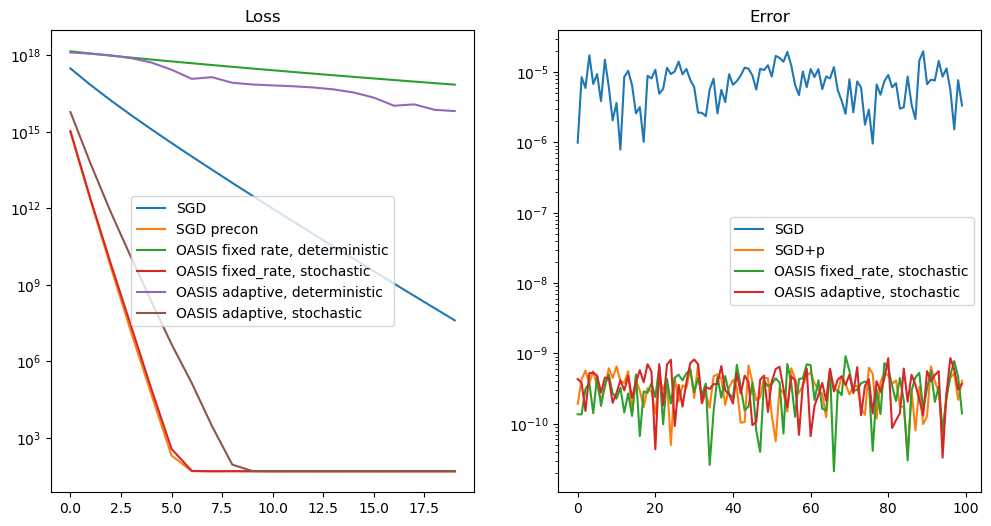

In [45]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)
plt.semilogy(loss_sgd)
plt.semilogy(loss_sgdp)
plt.semilogy(loss_o)
plt.semilogy(loss_os)
plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
plt.legend(
    [
        "SGD",
        "SGD precon",
        "OASIS fixed rate, deterministic",
        "OASIS fixed_rate, stochastic",
        "OASIS adaptive, deterministic",
        "OASIS adaptive, stochastic",
    ]
)
# plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.semilogy(jnp.abs(x_sgd - x_gt))
plt.semilogy(jnp.abs(x_sgdp - x_gt))
# plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os - x_gt))
# plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa - x_gt))
# plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(
    ["SGD", "SGD+p", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"]
)
plt.title("Error")

plt.rcParams["figure.figsize"] = 6, 6

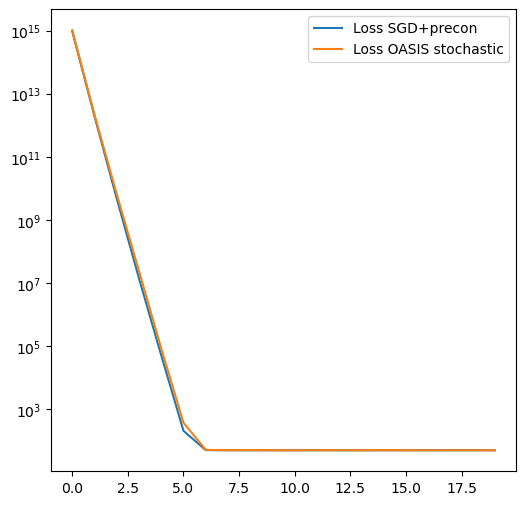

In [46]:
plt.semilogy(loss_sgdp)
plt.semilogy(loss_os)
plt.legend(["Loss SGD+precon", "Loss OASIS stochastic"])

In [47]:
print(Fidx(x_gt, jnp.arange(N)))
print(Fidx(x_sgd, jnp.arange(N)))
print(Fidx(x_sgdp, jnp.arange(N)))
print(Fidx(x_o, jnp.arange(N)))
print(Fidx(x_os, jnp.arange(N)))
print(Fidx(x_oa, jnp.arange(N)))
print(Fidx(x_osa, jnp.arange(N)))

50.11836749954431
40710472.10532289
50.192421919840825
6.930496737029799e+16
50.173863272194524
6407583599597824.0
50.172599677552014
